# NVAE Debug Experiment (Fast Run)

This is a DEBUG version of the experiment notebook. It uses a **subset of data (10%)** and **fewer epochs** to ensure the pipeline works quickly (under 30 mins).

## 1. Google Colab Setup
Mount Drive and clone the repository.

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import shutil

# --- CONFIGURATION ---
REPO_PATH = '/content/drive/MyDrive/Generative-Modeling-on-CIFAR-10'
REPO_URL = "https://github.com/konstantine25b/Generative-Modeling-on-CIFAR-10.git"

# 1. Clone if not exists
if not os.path.exists(REPO_PATH):
    print(f"Cloning repository to {REPO_PATH}...")
    os.chdir('/content/drive/MyDrive')
    !git clone {REPO_URL}
else:
    print(f"Repository already exists at {REPO_PATH}")

# 2. Enter the repository
os.chdir(REPO_PATH)
print(f"Current working directory: {os.getcwd()}")

# 3. Add source code to Python path
sys.path.append(os.path.join(REPO_PATH, 'src'))

Mounted at /content/drive
Cloning repository to /content/drive/MyDrive/Generative-Modeling-on-CIFAR-10...
Cloning into 'Generative-Modeling-on-CIFAR-10'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 74 (delta 12), reused 37 (delta 8), pack-reused 33 (from 1)
Receiving objects: 100% (74/74), 211.39 MiB | 18.42 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Updating files: 100% (30/30), done.
Current working directory: /content/drive/MyDrive/Generative-Modeling-on-CIFAR-10


## 2. GitHub Configuration (Optional)

In [2]:
# GitHub Configuration & Setup
import os

try:
    # 1. Configure Git
    user_name = "konstantine25b"
    mail = "konstantine25b@gmail.com"

    # --- IMPORTANT: PASTE YOUR TOKEN BELOW ---
    my_token = "YOUR_TOKEN_HERE"

    if my_token == "YOUR_TOKEN_HERE":
        print("⚠️ PLEASE UPDATE 'my_token' in the code cell with your actual GitHub token to enable pushing.")

    repo_url = f"https://{my_token}@github.com/konstantine25b/Generative-Modeling-on-CIFAR-10.git"

    !git config --global user.name "{user_name}"
    !git config --global user.email "{mail}"

    # 2. Set Remote URL
    if os.path.isdir(".git") and my_token != "YOUR_TOKEN_HERE":
        !git remote set-url origin "{repo_url}"
        print("Git configured successfully for pushing.")
    else:
        print("Skipping remote setup (either not a git repo or token not set).")

except Exception as e:
    print(f"Error setting up GitHub: {e}")

⚠️ PLEASE UPDATE 'my_token' in the code cell with your actual GitHub token to enable pushing.
Skipping remote setup (either not a git repo or token not set).


## 3. Install Dependencies

In [3]:
!pip install -r requirements.txt
!pip install wandb -q
# !wandb login # Uncomment to login

## 4. Setup DEBUG Experiment (Fast Config)

In [4]:
import torch
from src.utils.data_loader import get_cifar10_loaders
from src.vae.train import train_vae
from src.vae.sampling import generate_samples, save_sample_grid
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# DEBUG Configuration
config = {
    'epochs': 5,          # Reduced from 50 to 5 for speed
    'batch_size': 64,
    'lr': 1e-3,
    'hidden_dim': 64,
    'latent_dim': 20,
    'num_scales': 2,
    'warmup_epochs': 2,   # Reduced warmup
    'weight_decay': 3e-4,
    'use_wandb': False,   # Set to True if you want to test logging too
    'run_name': 'nvae_debug_run',
    'model_save_dir': 'models/debug',
    'results_dir': 'results/debug'
}

# Create directories
os.makedirs(config['model_save_dir'], exist_ok=True)
os.makedirs(config['results_dir'], exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## 5. Load SUBSET of Data
We wrap the data loader to use only 10% of the data.

In [5]:
from torch.utils.data import DataLoader, Subset

# Get full datasets first
# We use a trick: get the loaders, then access their datasets
full_train_loader, full_val_loader, full_test_loader = get_cifar10_loaders(
    data_dir='./data',
    batch_size=config['batch_size']
)

# Function to create subset loader
def create_subset_loader(original_loader, fraction=0.1):
    dataset = original_loader.dataset
    subset_size = int(len(dataset) * fraction)
    # Just take the first N indices for determinism
    indices = list(range(subset_size))
    subset = Subset(dataset, indices)

    return DataLoader(
        subset,
        batch_size=original_loader.batch_size,
        shuffle=True if original_loader.dataset == full_train_loader.dataset else False,
        num_workers=2,
        pin_memory=True
    )

# Create 10% subsets
print("Creating 10% data subsets for fast debugging...")
train_loader = create_subset_loader(full_train_loader, fraction=0.1)
val_loader = create_subset_loader(full_val_loader, fraction=0.2) # 20% of val set

print(f"Debug Train Loader: {len(train_loader)} batches (approx {len(train_loader.dataset)} images)")
print(f"Debug Val Loader: {len(val_loader)} batches")

Data Loaders ready: Train=45000, Val=5000, Test=10000
Creating 10% data subsets for fast debugging...
Debug Train Loader: 71 batches (approx 4500 images)
Debug Val Loader: 16 batches


## 6. Train Model (Fast Run)

In [6]:
# Start Training
train_vae(config, train_loader, val_loader, device)

Model initialized on cuda


Epoch 1/5: 100%|██████████| 71/71 [00:10<00:00,  7.02it/s, loss=1798.67, bpd=0.84, beta=0.50]


=== Epoch 1 Summary ===
Train Loss: 1916.9220 | Recon: 1863.1501 | KL: 107.5437 | BPD: 0.9002


Val Loss:   2113.2980 | Val BPD: 0.9925
✅ Saved best model to models/debug/nvae_best.pth (Val Loss: 2113.2980)


Epoch 2/5: 100%|██████████| 71/71 [00:08<00:00,  8.87it/s, loss=1868.30, bpd=0.88, beta=1.00]


=== Epoch 2 Summary ===
Train Loss: 1880.9000 | Recon: 1828.7616 | KL: 52.1384 | BPD: 0.8833


Val Loss:   1873.9875 | Val BPD: 0.8801
✅ Saved best model to models/debug/nvae_best.pth (Val Loss: 1873.9875)


Epoch 3/5: 100%|██████████| 71/71 [00:07<00:00,  9.14it/s, loss=1801.16, bpd=0.85, beta=1.00]


=== Epoch 3 Summary ===
Train Loss: 1861.3839 | Recon: 1813.3685 | KL: 48.0154 | BPD: 0.8742


Val Loss:   1859.8869 | Val BPD: 0.8735
✅ Saved best model to models/debug/nvae_best.pth (Val Loss: 1859.8869)


Epoch 4/5: 100%|██████████| 71/71 [00:08<00:00,  8.79it/s, loss=1874.60, bpd=0.88, beta=1.00]


=== Epoch 4 Summary ===
Train Loss: 1854.8068 | Recon: 1806.0521 | KL: 48.7547 | BPD: 0.8711


Val Loss:   1855.0884 | Val BPD: 0.8712
✅ Saved best model to models/debug/nvae_best.pth (Val Loss: 1855.0884)


Epoch 5/5: 100%|██████████| 71/71 [00:08<00:00,  8.74it/s, loss=1865.80, bpd=0.88, beta=1.00]


=== Epoch 5 Summary ===
Train Loss: 1851.1631 | Recon: 1802.5482 | KL: 48.6149 | BPD: 0.8694


Val Loss:   1850.9420 | Val BPD: 0.8693
✅ Saved best model to models/debug/nvae_best.pth (Val Loss: 1850.9420)


## 7. Generate Samples

Loaded best model.


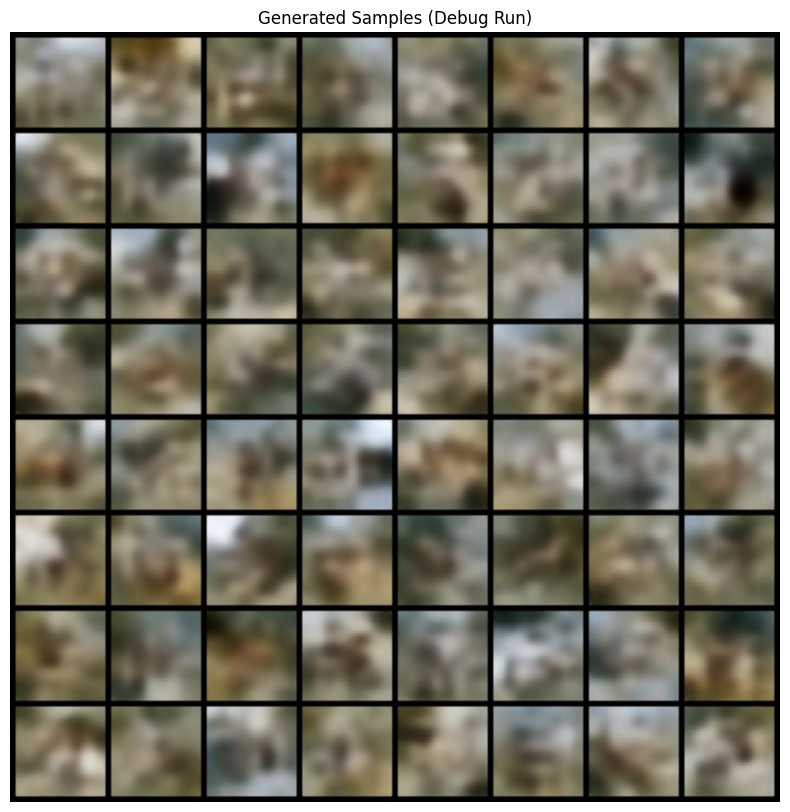

In [7]:
# Load best model
from src.vae.model import NVAE

model = NVAE(
    hidden_dim=config['hidden_dim'],
    latent_dim=config['latent_dim'],
    num_scales=config['num_scales']
).to(device)

model.load_state_dict(torch.load(os.path.join(config['model_save_dir'], 'nvae_best.pth')))
print("Loaded best model.")

# Generate
samples = generate_samples(model, num_samples=64, temperature=0.8, device=device)

# Visualize
plt.figure(figsize=(10, 10))
grid_img = torchvision.utils.make_grid(samples, nrow=8, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.title("Generated Samples (Debug Run)")
plt.show()